In [1]:
import matplotlib.pyplot as plt

In [2]:
import pyomo.environ as pyo

In [309]:
import numpy as np
import pandas as pd



In [373]:
data = pd.read_csv("DebrisFlow.txt",sep ='\t',header = None)

In [374]:
model = pyo.ConcreteModel()

In [375]:
M = [max( abs(data.iloc[i][1] - 0.29*data.iloc[i][0]-25) , abs(data.iloc[i][1] - 0.29*data.iloc[i][0]+94),
        abs(data.iloc[i][1]-25) , abs(data.iloc[i][1] +94)) for i in range(len(data))]

In [376]:
M2 = [119+0.3*data.iloc[i][0] for i in range(len(data))]

In [377]:
I = np.arange(len(data)) +1

In [378]:
model.Iset = pyo.Set(initialize=I)
model.I = pyo.Param(initialize=len(I))

In [379]:
def rule_x(model,i):
    return data.iloc[i-1][0]
def rule_y(model,i):
    return data.iloc[i-1][1]

In [380]:
B = np.arange(5)+1


In [381]:
model.Bset = pyo.Set(initialize=B)
model.B = pyo.Param(initialize=len(B))


In [382]:
model.X = pyo.Param(model.Iset,initialize=rule_x)

In [383]:
model.Y = pyo.Param(model.Iset,initialize=rule_y)

In [384]:
model.c = pyo.Var(model.Bset,domain=pyo.Reals,bounds=(0,0.3))

In [385]:
model.d = pyo.Var(model.Bset,domain=pyo.Reals,bounds=(-94,25))

In [386]:
model.eps = pyo.Var(model.Iset,domain = pyo.NonNegativeReals)

In [387]:
model.delta = pyo.Var(model.Iset,model.Bset,domain = pyo.Binary)

In [388]:
model.deltap = pyo.Var(model.Iset,model.Bset,domain=pyo.Reals, bounds=(0,1))

In [389]:
model.deltan = pyo.Var(model.Iset,model.Bset,domain=pyo.Reals, bounds=(0,1))

In [390]:
model.gamma = pyo.Var(model.Bset,domain=pyo.Binary)

In [391]:
def M_rule(model,i):
    return M[i-1]

In [392]:
model.M = pyo.Param(model.Iset,initialize=M_rule)

In [393]:
def M2_rule(model,i):
    return M2[i-1]

In [394]:
model.M2 = pyo.Param(model.Iset,initialize=M2_rule)

In [395]:
def rule_const1(model,i,b):
    if b==model.B:
        return pyo.Constraint.Skip
    
    return model.Y[i] - model.c[b]*model.X[i] - model.d[b] <= model.eps[i] + model.M[i]*(1-model.delta[i,b])

In [396]:
model.const1 = pyo.Constraint(model.Iset,model.Bset,rule = rule_const1)

In [397]:
def rule_const2(model,i,b):
    if b==model.B:
        return pyo.Constraint.Skip
    
    return -1*model.Y[i] + model.c[b]*model.X[i] + model.d[b] <= model.eps[i] + model.M[i]*(1-model.delta[i,b])

In [398]:
model.const2 = pyo.Constraint(model.Iset,model.Bset,rule=rule_const2)

In [399]:
def rule_const3(model,i):
    return sum(model.delta[i,b] for b in model.Bset if b!=model.B) == 1

In [400]:
model.const3 = pyo.Constraint(model.Iset,rule=rule_const3)

In [401]:
def rule_const_4(model,i,b):
    
    if i==model.I:
        return pyo.Constraint.Skip
    
    if b == model.B:
        return pyo.Constraint.Skip
    
    return model.delta[i+1,b+1] <= model.delta[i,b] + model.delta[i,b+1]

In [402]:
def rule_const_5(model,i):
    
    if i==model.I:
        return pyo.Constraint.Skip
 
    
    return model.delta[i+1,1] <= model.delta[i,1] 

In [403]:
def rule_const_6(model,i):
    
    if i==model.I:
        return pyo.Constraint.Skip
 
    
    return model.delta[i,model.B] <= model.delta[i+1,model.B] 

In [404]:
model.const4 = pyo.Constraint(model.Iset,model.Bset,rule = rule_const_4)

In [405]:
model.const5 = pyo.Constraint(model.Iset,rule = rule_const_5)

In [406]:
model.const6 = pyo.Constraint(model.Iset, rule = rule_const_6)

In [407]:
def rule_const_7(model,i,b):
    if i == model.I:
        return pyo.Constraint.Skip
    if b > model.B-2:
        return pyo.Constraint.Skip
    
    return model.delta[i,b] + model.delta[i+1,b+1] + model.gamma[b] -2 <= model.deltap[i,b]

In [408]:
model.const7 = pyo.Constraint(model.Iset,model.Bset, rule = rule_const_7)

In [409]:
def rule_const_8(model,i,b):
    if i == model.I:
        return pyo.Constraint.Skip
    if b > model.B-2:
        return pyo.Constraint.Skip
    
    return model.delta[i,b] + model.delta[i+1,b+1] + 1-model.gamma[b] -2 <= model.deltan[i,b]

In [410]:
model.const8 = pyo.Constraint(model.Iset,model.Bset, rule = rule_const_8)

In [411]:
def rule_const_9(model,i,b):
    if i == model.I:
        return pyo.Constraint.Skip
    if b > model.B-2:
        return pyo.Constraint.Skip
    
    return model.d[b+1] - model.d[b]>= model.X[i]*(model.c[b]-model.c[b+1])-model.M2[i]*(1-model.deltap[i,b])

In [412]:
model.const9 = pyo.Constraint(model.Iset,model.Bset, rule = rule_const_9)

In [413]:
def rule_const_10(model,i,b):
    if i == model.I:
        return pyo.Constraint.Skip
    if b > model.B-2:
        return pyo.Constraint.Skip
    
    return model.d[b+1] - model.d[b] <= model.X[i+1]*(model.c[b]-model.c[b+1])-model.M2[i+1]*(1-model.deltap[i,b])

In [414]:
model.const10 = pyo.Constraint(model.Iset,model.Bset, rule = rule_const_10)

In [415]:
def rule_const_11(model,i,b):
    if i == model.I:
        return pyo.Constraint.Skip
    if b > model.B-2:
        return pyo.Constraint.Skip
    
    return model.d[b+1] - model.d[b] <= model.X[i]*(model.c[b]-model.c[b+1])-model.M2[i]*(1-model.deltan[i,b])

In [416]:
model.const11 = pyo.Constraint(model.Iset,model.Bset, rule = rule_const_11)

In [417]:
def rule_const_12(model,i,b):
    if i == model.I:
        return pyo.Constraint.Skip
    if b > model.B-2:
        return pyo.Constraint.Skip
    
    return model.d[b+1] - model.d[b] >= model.X[i+1]*(model.c[b]-model.c[b+1])-model.M2[i+1]*(1-model.deltan[i,b])

In [418]:
model.const12= pyo.Constraint(model.Iset,model.Bset, rule = rule_const_12)


In [419]:
def rc13(model,b):
    if b == model.B:
        return pyo.Constraint.Skip
    
    return sum(model.delta[i,b] for i in model.Iset) >= 2

In [420]:
model.const13 = pyo.Constraint(model.Bset,rule=rc13)

In [421]:
def rule_obj(model):
    return sum(model.eps[i] for i in model.Iset)

In [422]:
model.obj = pyo.Objective(rule=rule_obj,sense = pyo.minimize)

In [423]:
solver = pyo.SolverFactory('glpk')

In [424]:
opt = {'tmlim':1200}

In [367]:
result = solver.solve(model, options = opt)

In [368]:
breaks = []
k=len(B)-1

breaks.append(1)

for i in range(1,len(data)+1):
    
    for j in range(1,k):
        
        if pyo.value(model.delta[i,j]) == 1:
            if pyo.value(model.delta[i+1,j])!=1:
                breaks.append(i)
            
breaks.append(len(data))

In [369]:
breaks = np.array(breaks)
breaks = breaks - 1

In [370]:
color = {1:'red',2:'orange',3:'green',4:'darkviolet',5:'lime'}

# 5 breakpoints

In [177]:
print(result)


Problem: 
- Name: unknown
  Lower bound: 86.8262497581624
  Upper bound: 86.8262497581624
  Number of objectives: 1
  Number of constraints: 1433
  Number of variables: 534
  Number of nonzeros: 6061
  Sense: minimize
Solver: 
- Status: ok
  Termination condition: optimal
  Statistics: 
    Branch and bound: 
      Number of bounded subproblems: 1645
      Number of created subproblems: 1645
  Error rc: 0
  Time: 14.598718166351318
Solution: 
- number of solutions: 0
  number of solutions displayed: 0



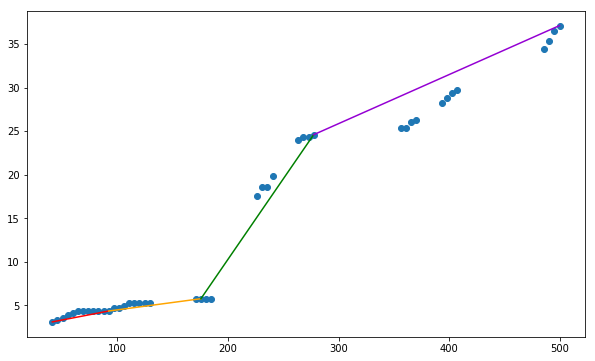

In [178]:
plt.figure(figsize=(10,6))
plt.scatter(data[0],data[1])
for i in range(1,len(breaks)):
    
    plt.plot([data[0][breaks[i-1]],data[0][breaks[i]]],[data[1][breaks[i-1]],data[1][breaks[i]]],c=color[i])